In [6]:
!pip install yfinance

In [7]:
import yfinance as yf

In [8]:
symbol = 'AAPL'
start_date = '2014-01-01'
end_date = '2024-01-01'

In [9]:
df = yf.download(symbol, start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed


In [10]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.273224,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.893808,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,16.985931,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.864460,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.971254,258529600
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Year         0
Month        0
Day          0
DayOfWeek    0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Year         0
Month        0
Day          0
DayOfWeek    0
dtype: int64
13/13 [==============================] - 1s 18ms/step
Mean Squared Error: 47.61111050199105
13/13 [==============================] - 0s 18ms/step


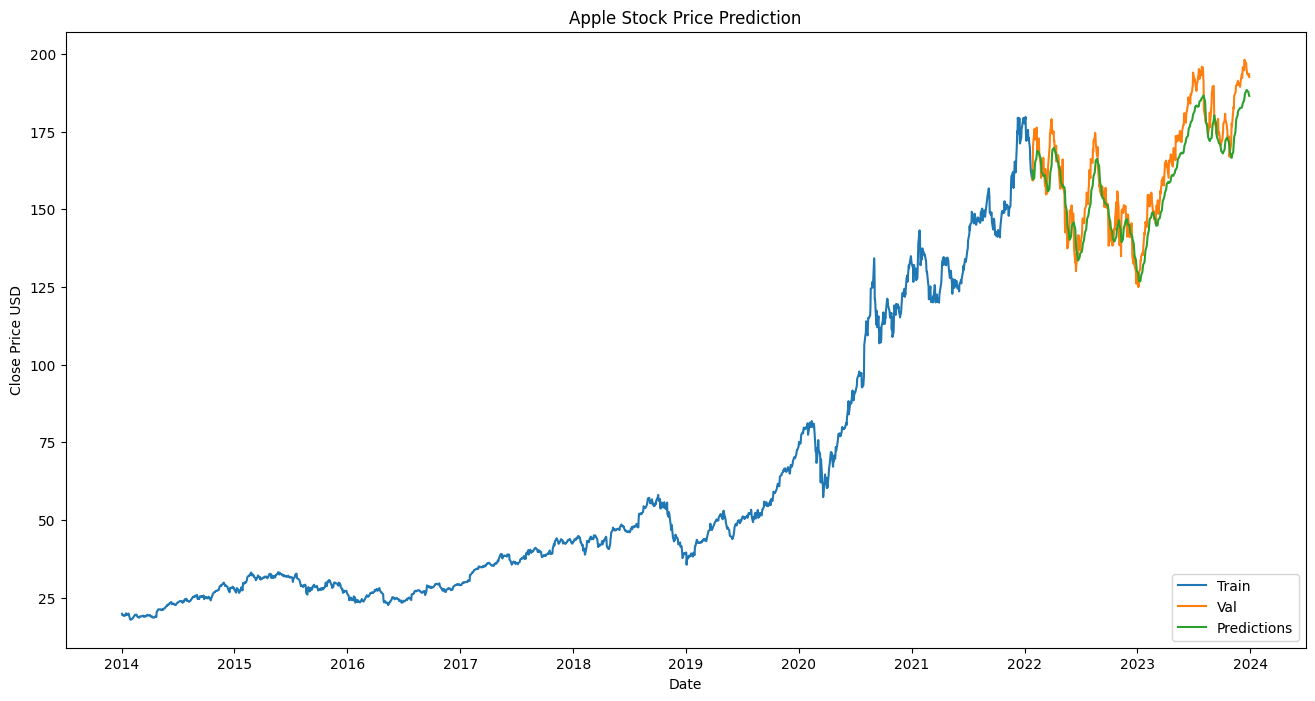

1/1 [==============================] - 0s 32ms/step


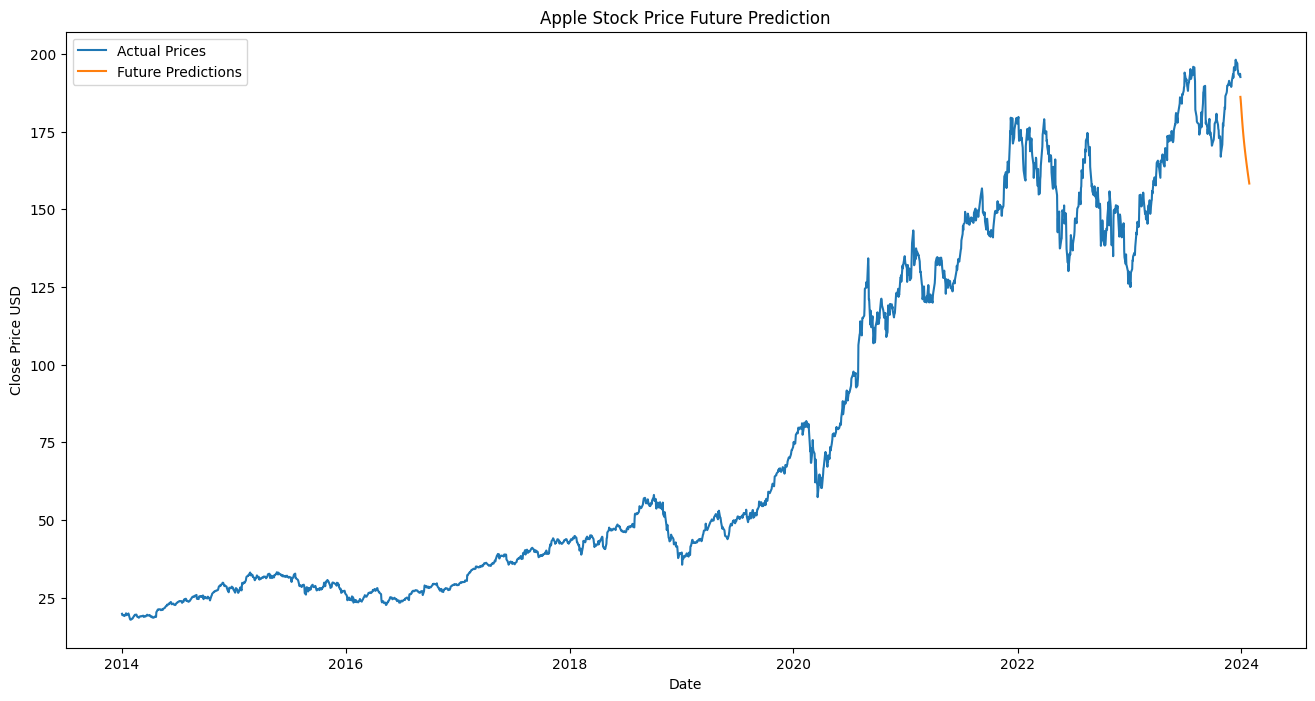

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout

df.head()

df['Date'] = df.index
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df.set_index('Date',inplace=True)
df.sort_index(ascending=True, inplace=True)
data = df[['Close']].values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

print(df.isnull().sum())
df.dropna(inplace=True)
print((df == 0).sum())
df = df[(df != 0).all(axis=1)]

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=1, epochs=1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

mse = np.mean((predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))**2)
print(f'Mean Squared Error: {mse}')

train = df[:split + seq_length]
valid = df[split + seq_length:]
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
predictions_df = pd.DataFrame(predictions, columns=['Predictions'], index=df.index[split + seq_length:])
valid = valid.join(predictions_df)

plt.figure(figsize=(16, 8))
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

def predict_future_prices(model, data, seq_length, future_steps):
    future_predictions = []
    last_sequence = data[-seq_length:]
    for _ in range(future_steps):
        next_pred = model.predict(last_sequence.reshape(1, seq_length, 1))
        future_predictions.append(next_pred[0, 0])
        last_sequence = np.append(last_sequence[1:], next_pred)
    return np.array(future_predictions).reshape(-1, 1)

future_steps = 30
future_predictions = predict_future_prices(model, scaled_data, seq_length, future_steps)
future_predictions = scaler.inverse_transform(future_predictions)


plt.figure(figsize=(16, 8))
plt.title('Apple Stock Price Future Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(df.index, df['Close'], label='Actual Prices')
future_dates = pd.date_range(df.index[-1], periods=future_steps)
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.legend()
plt.show()
